In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image, ImageOps
import time
import torch.nn as nn
# %matplotlib inline
import os
import torch
from torch.autograd import Variable
import math
from skimage.measure import compare_psnr
dtype = torch.cuda.FloatTensor

In [8]:
class Concat(nn.Module):
    def __init__(self, dim, skip, deeper):
        super(Concat, self).__init__()
        self.dim = dim
        self.layer1 = skip
        self.layer2 = deeper
    def forward(self, input):
        inputs = []
        inputs.append(self.layer1(input))
        inputs.append(self.layer2(input))
        return torch.cat(inputs, dim=self.dim)

def get_name(name):
    name[0] +=1
    return str(name[0])

def skip(c_in, c_out, c_down, c_up, c_skip, k_down, k_up, k_skip, upsample_mode):
    model = nn.Sequential()
    model_tmp = model
    input_depth = c_in
    name = [0]
    for i in range(len(c_down)):
        layer = nn.Sequential()
        layer.add_module(get_name(name),nn.Conv2d(input_depth, c_down[i], k_down, 2, padding=int((k_down - 1) / 2)))
        layer.add_module(get_name(name),nn.BatchNorm2d(c_down[i]))
        layer.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))

        layer.add_module(get_name(name),nn.Conv2d(c_down[i], c_down[i], k_down, 1, padding=int((k_down - 1) / 2)))
        layer.add_module(get_name(name),nn.BatchNorm2d(c_down[i]))
        layer.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))

        deeper_main = nn.Sequential()
        
        if i < len(c_down)-1:
            layer.add_module(get_name(name),deeper_main)
            layer.add_module(get_name(name),nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                concat_layers = []
                concat_layers.append(nn.Conv2d(input_depth, c_skip[i], k_skip, 1, padding=int((k_skip - 1) / 2)))
                concat_layers.append(nn.BatchNorm2d(c_skip[i]))
                concat_layers.append(nn.LeakyReLU(0.2, inplace=True))
                model_tmp.add_module(get_name(name),Concat(1, nn.Sequential(*concat_layers), layer))
            else:
                model_tmp.add_module(get_name(name),layer)
            model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_skip[i] + c_up[i + 1] ))
            model_tmp.add_module(get_name(name),nn.Conv2d(c_skip[i] + c_up[i + 1], c_up[i], k_up, 1, padding=int((k_up - 1) / 2)))
            
        else:#last layer
            layer.add_module(get_name(name),nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                concat_layers = []
                concat_layers.append(nn.Conv2d(input_depth, c_skip[i], k_skip, 1, padding=int((k_skip - 1) / 2)))
                concat_layers.append(nn.BatchNorm2d(c_skip[i]))
                concat_layers.append(nn.LeakyReLU(0.2, inplace=True))
                model_tmp.add_module(get_name(name),Concat(1, nn.Sequential(*concat_layers), layer))
            else:
                model_tmp.add_module(get_name(name),layer)
            model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_skip[i] +c_down[i]))
            model_tmp.add_module(get_name(name),nn.Conv2d(c_skip[i] + c_down[i], c_up[i], k_up, 1, padding=int((k_up - 1) / 2)))

        model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_up[i]))
        model_tmp.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))
        model_tmp.add_module(get_name(name),nn.Conv2d(c_up[i], c_up[i], 1, 1))
        model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_up[i]))
        model_tmp.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))
        input_depth = c_down[i]
        model_tmp = deeper_main

    model.add_module(get_name(name),nn.Conv2d(c_up[0], c_out, 1, 1))
    model.add_module(get_name(name),nn.Sigmoid())

    return model

In [9]:
def preprocess_input_with_mask(img, mask):
    img = Image.open(img)
#     img.resize((512,512), Image.ANTIALIAS)
    img = ImageOps.fit(img, (512,512), Image.ANTIALIAS)
    plt.imshow(img)
    mask = Image.open(mask)
    plt.figure()
    plt.imshow(mask,cmap='gray')
    img = np.array(img).transpose(2,0,1)
    print(img.shape)
    img = img[:3,:512,:512]/255
    mask = np.array(mask)[None, :]/255
    processed_img = img*mask
    plt.figure()
    plt.imshow(processed_img.transpose(1,2,0))
#     img = (torch.from_numpy(img)[None,:]).type(dtype)
    mask = (torch.from_numpy(mask)[None,:]).type(dtype)
    processed_img = (torch.from_numpy(processed_img)[None,:]).type(dtype)
    return img, mask, processed_img 

In [10]:
def preprocess_input(img):
    img = Image.open(img)
#     img.resize((512,512), Image.ANTIALIAS)
    img = ImageOps.fit(img, (512,512), Image.ANTIALIAS)
    plt.imshow(img)
    img = np.array(img)
    print(img.shape)
    
    tmp = np.random.choice(512*512, 512*512//2)
    processed_img = img.copy()
    
    if len(img.shape)<3:
        
        img = img[:512,:512]/255
        mask = np.ones((512,512))
        for i in tmp:
            mask[i//512,i%512] = 0
        plt.figure()
        plt.imshow(mask, cmap='gray')
        
        processed_img = img*mask
        
        plt.figure()
        plt.imshow(processed_img)
        
    else:
        img = np.array(img).transpose(2,0,1)
        img = img[:3,:512,:512]/255
        mask = np.ones((3,512,512))
        for i in tmp:
            mask[:,i//512,i%512] = 0
        plt.figure()
        plt.imshow(mask.transpose(1,2,0))
        
        processed_img = img*mask
    
        plt.figure()
        plt.imshow(processed_img.transpose(1,2,0))

    mask = (torch.from_numpy(mask)[None,:]).type(dtype)
    processed_img = (torch.from_numpy(processed_img)[None,:]).type(dtype)
    return img, mask, processed_img 

(4, 512, 512)


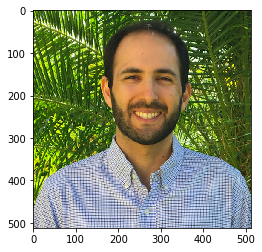

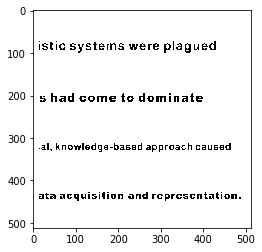

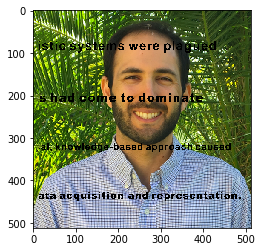

In [11]:
base_dir = 'data/inpainting_dataset/'
img = base_dir+'justin.png'
mask = base_dir+'justin_mask.png'
img, mask, processed_img = preprocess_input_with_mask(img, mask)

/home/yujiaq3/venv_python3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/home/yujiaq3/venv_python3/lib/python3.7/site-packages/skimage/measure/simple_metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  return peak_signal_noise_ratio(im_true, im_test, data_range=data_range)


Op time: 0.135254
Iteration 00000  Loss 0.079478  PSNR 10.818003
3


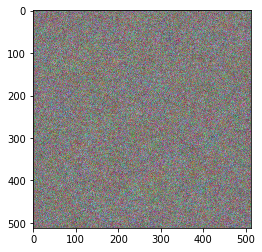

Op time: 10.609142
Iteration 00100  Loss 0.018239  PSNR 17.166144
3


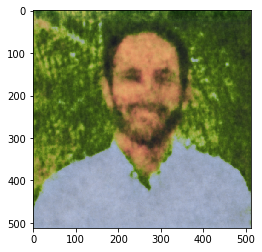

Op time: 20.722392
Iteration 00200  Loss 0.012294  PSNR 18.839414
3


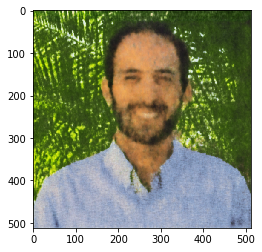

Op time: 31.560980
Iteration 00300  Loss 0.009846  PSNR 19.768795
3


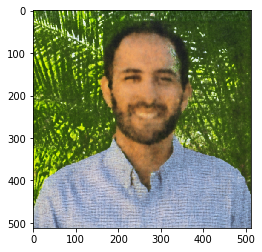

Op time: 42.681699
Iteration 00400  Loss 0.007385  PSNR 20.969792
3


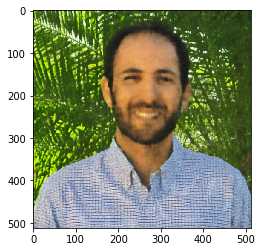

Op time: 53.728715
Iteration 00500  Loss 0.005622  PSNR 22.081572
3


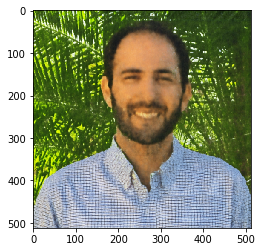

Op time: 64.715731
Iteration 00600  Loss 0.004553  PSNR 22.987292
3


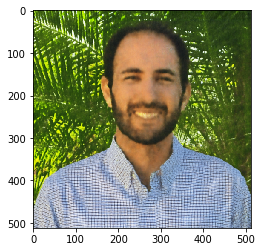

Op time: 76.114542
Iteration 00700  Loss 0.003836  PSNR 23.641267
3


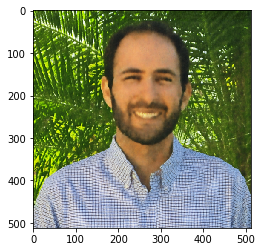

Op time: 86.747464
Iteration 00800  Loss 0.003281  PSNR 24.305040
3


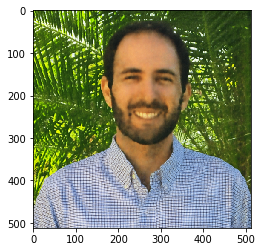

Op time: 97.322656
Iteration 00900  Loss 0.002856  PSNR 24.873115
3


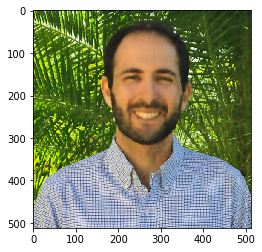

Op time: 107.738403
Iteration 01000  Loss 0.002522  PSNR 25.329592
3


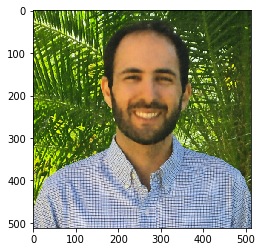

Op time: 118.983805
Iteration 01100  Loss 0.002243  PSNR 25.832852
3


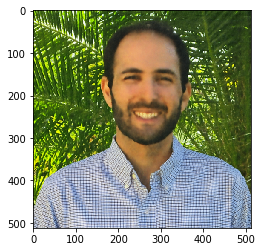

Op time: 130.129253
Iteration 01200  Loss 0.002008  PSNR 26.264932
3


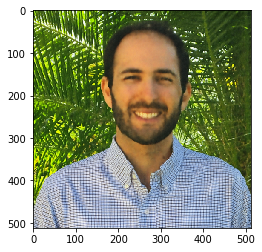

Op time: 141.304503
Iteration 01300  Loss 0.001891  PSNR 26.476734
3


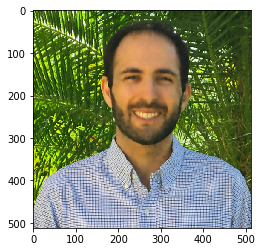

Op time: 152.534766
Iteration 01400  Loss 0.001670  PSNR 26.952431
3


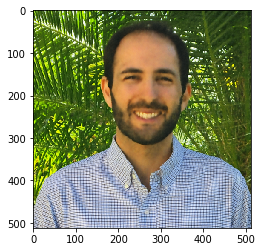

Op time: 163.807651
Iteration 01500  Loss 0.001520  PSNR 27.308344
3


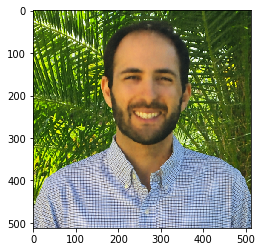

Op time: 174.181637
Iteration 01600  Loss 0.001432  PSNR 27.563750
3


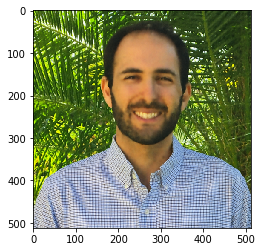

Op time: 184.148375
Iteration 01700  Loss 0.001322  PSNR 27.834355
3


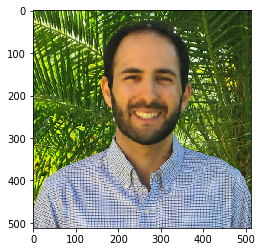

Op time: 195.142338
Iteration 01800  Loss 0.001237  PSNR 28.057393
3


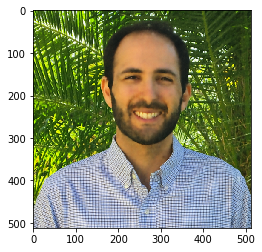

Op time: 205.420323
Iteration 01900  Loss 0.001126  PSNR 28.425790
3


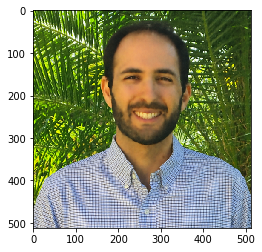

Op time: 215.948304
Iteration 02000  Loss 0.001063  PSNR 28.618555
3


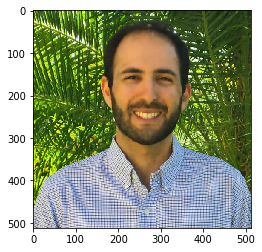

Op time: 226.275229
Iteration 02100  Loss 0.001002  PSNR 28.862304
3


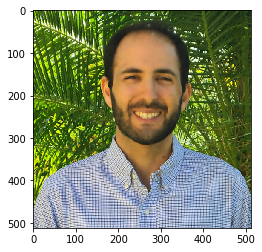

Op time: 242.004294
Iteration 02200  Loss 0.000927  PSNR 29.103538
3


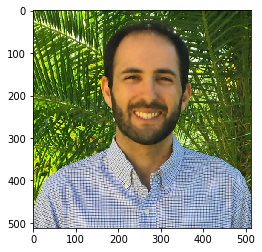

Op time: 259.688670
Iteration 02300  Loss 0.000844  PSNR 29.408279
3


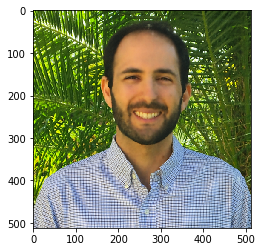

Op time: 277.061452
Iteration 02400  Loss 0.000797  PSNR 29.633620
3


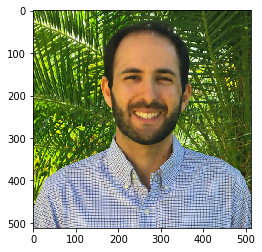

Op time: 294.786570
Iteration 02500  Loss 0.000725  PSNR 29.920995
3


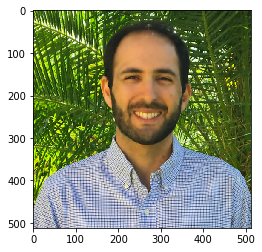

Op time: 312.491424
Iteration 02600  Loss 0.000701  PSNR 30.051155
3


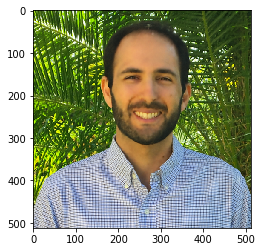

In [ ]:
input_depth = 32
LR = 0.01 
num_iter = 5001
reg_noise_std = 0.03
if len(processed_img.shape)<4:
    c = 1
    w,h = processed_img.shape[1],processed_img.shape[2]
else:
    c = processed_img.shape[1]
    w,h = processed_img.shape[2], processed_img.shape[3]
    

model = skip(input_depth, c, 
               c_down = [128] * 5,
               c_up =   [128] * 5,
               c_skip =    [128] * 5,  
               k_up = 3, k_down = 3, 
               upsample_mode='nearest', k_skip=1).type(dtype)
# print(model)

mse = torch.nn.MSELoss().type(dtype)

net_input = torch.zeros([1, input_depth, w, h])
net_input = net_input.type(dtype)
net_input.uniform_() #net_input.normal_()
net_input *= 0.1           
noise = net_input.detach().clone()
net_input_saved = net_input.detach().clone()

params = [x for x in model.parameters()]
optimizer = torch.optim.Adam(params, lr=LR)
PSNR = []
start = time.time()
for i in range(num_iter):
    optimizer.zero_grad()
    
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = model(net_input)

    loss = mse(out * mask, processed_img)
    loss.backward()
    
    optimizer.step()
    out = out.detach().cpu().numpy()[0]
    if len(img.shape)>2:
        psnr = compare_psnr(img, out)
        PSNR.append(psnr)
    else:
        psnr = compare_psnr(img, out[0])
        PSNR.append(psnr)

    if i % 100 == 0:
        print("Op time: %f" % (time.time()-start))
        print('Iteration %05d  Loss %f  PSNR %f' % (i, loss.item(), psnr))
        plt.figure()
        print(len(out.shape))
        if len(img.shape)<3:
            plt.imshow(out[0])
        else:
            plt.imshow(out.transpose(1,2,0))
        plt.show()
print("Op time: %f" % (time.time()-start))

In [ ]:
plt.title("PSNR vs Epoch Plot")
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.plot(PSNR)

In [39]:
max(PSNR)

41.28234809039515